# Телеком

## Описание проекта. Телеком
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» __нужна модель, которая будет предсказывать, разорвёт ли абонент договор.__ Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. __Задача — обучить на этих данных модель для прогноза оттока клиентов.__

### Описание услуг
Оператор предоставляет два основных типа услуг:   
__Стационарную телефонную связь.__ Телефон можно подключить к нескольким линиям одновременно.   
__Интернет.__ Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:    
__Интернет-безопасность:__ антивирус (Device Protection) и блокировка опасных сайтов (Online Security);  
__Выделенная линия технической поддержки (Tech Support);__  
__Облачное хранилище файлов для резервного копирования данных (Online Backup);__  
__Стриминговое телевидение (Streaming TV)__ и __каталог фильмов (Streaming Movies).__  
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

__План проекта__:   
1)  Загрузить данные;  
2) Провести исследовательский анализ и предобработку данных;     
3) Обучить модель;  
4) Протестировать модель и продемонстрировать её работу;   
5) Сделать общий вывод по работе.  

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install imblearn

In [ ]:
!pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
# Загрузим необходимые библиотеки
import os

from sqlalchemy import create_engine, inspect
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik.report import plot_correlation_matrix
from phik import report


from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    learning_curve
    )
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder
                                  )
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    precision_recall_curve
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    GridSearchCV
)


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка данных

In [ ]:
RANDOM_STATE = 2602025

In [ ]:
# Подключение к базе данных
engine = create_engine(f'sqlite:///ds-plus-final.db', echo=False)

con = sqlite3.connect('ds-plus-final.db')
cur = con.cursor()

In [ ]:
res = cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [ ]:
# Проверяем какие таблицы есть в бд
res.fetchall()

[('data_arc',),
 ('data_bulk',),
 ('data_bulk_time',),
 ('data_wire_time',),
 ('contract',),
 ('personal',),
 ('phone',),
 ('internet',),
 ('data_gas',),
 ('data_temp',),
 ('data_wire',)]

Помимо наших основных таблицы - contract, personal, phone и internet видим другие таблицы.

Загрузим данные в виде датафреймов

In [ ]:
def read_df(name, connection):
    """
    Функция загрузки датафрейма
    """
    query = f"SELECT * FROM {name}"
    df = pd.read_sql(query, connection)
    return df

In [ ]:
contract_df = read_df('contract', con)
# Первые 5 строк
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [ ]:
contract_df['MonthlyCharges'] / contract_df['TotalCharges']

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
# Создадим новый признак (длительность контракта клиента)
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['time'] = contract_df['EndDate'].apply(lambda x: datetime.now() if x == 'No' else pd.to_datetime(x))
contract_df['ContractDuration'] = (contract_df['time'] - contract_df['BeginDate']).dt.days

In [ ]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,time,ContractDuration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,2025-06-06 17:42:25.569096,1983
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2025-06-06 17:42:25.569099,2988
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,2025-06-06 17:42:25.569100,2075
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,2025-06-06 17:42:25.569101,3323
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,2025-06-06 17:42:25.569101,2105


In [ ]:
contract_df = contract_df.drop('time', axis=1)

In [ ]:
rows = contract_df.shape[0]
cols = contract_df.shape[1]

In [ ]:
print(f'Количество строк - {rows}\nКоличество столбцов - {cols}')

Количество строк - 7043
Количество столбцов - 9


Таблица __contract (информация о договорах):__   
__customerID__ — ID абонента;     
__BeginDate__ — дата начала действия договора;    
__EndDate__ — дата окончания действия договора (наша целевая переменная);  
__Type__ — тип оплаты: раз в год-два или ежемесячно;  
__PaperlessBilling__ — электронный расчётный лист;  
__PaymentMethod__ — тип платежа;   
__MonthlyCharges__ — расходы за месяц;   
__TotalCharges__ — общие расходы абонента.  

In [ ]:
personal_df = read_df('personal', con)
# Первые 5 строк
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
print(f'Количество строк - {personal_df.shape[0]}\nКоличество столбцов - {personal_df.shape[1]}')

Количество строк - 7043
Количество столбцов - 5


Таблица __personal (персональные данные клиентов):__     
__customerID__ — ID пользователя;  
__gender__ — пол;  
__SeniorCitizen__ — является ли абонент пенсионером;    
__Partner__ — есть ли у абонента супруг или супруга;    
__Dependents__ — есть ли у абонента дети.  

In [ ]:
internet_df = read_df('internet', con)
# Первые 5 строк
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
print(f'Количество строк - {internet_df.shape[0]}\nКоличество столбцов - {internet_df.shape[1]}')

Количество строк - 5517
Количество столбцов - 8


Таблица __internet (информация об интернет-услугах):__      
__customerID__ — ID пользователя;  
__InternetService__ — тип подключения;  
__OnlineSecurity__ — блокировка опасных сайтов;  
__OnlineBackup__ — облачное хранилище файлов для резервного копирования данных;   
__DeviceProtection__ — антивирус;  
__TechSupport__ — выделенная линия технической поддержки;  
__StreamingTV__ — стриминговое телевидение;  
__StreamingMovies__ — каталог фильмов.  

In [ ]:
phone_df = read_df('phone', con)
# Первые 5 строк
phone_df.head()

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
print(f'Количество строк - {phone_df.shape[0]}\nКоличество столбцов - {phone_df.shape[1]}')

Количество строк - 6361
Количество столбцов - 2


Таблица __phone (информация об услугах телефонии):__  
__customerID__ — ID пользователя;  
__MultipleLines__ — подключение телефона к нескольким линиям одновременно.  

__Вывод по загрузке данных__:
1. Загрузили данные;
2. Проанализировали датасеты - заметили общий столбец customerID.

## 2. Предобработка данных

In [ ]:
# Заменим customerID на CustomerID
contract_df = contract_df.rename(columns={contract_df.columns[0]: 'CustomerID'})
personal_df = personal_df.rename(columns={personal_df.columns[0]: 'CustomerID', personal_df.columns[1]: 'Gender'})
internet_df = internet_df.rename(columns={internet_df.columns[0]: 'CustomerID'})
phone_df = phone_df.rename(columns={phone_df.columns[0]: 'CustomerID'})

#### contract_df

In [ ]:
# Выводим общую информацию по данным
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   object        
 7   TotalCharges      7043 non-null   object        
 8   ContractDuration  7043 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 495.3+ KB


Пропусков в датасете нет, но последние две колоноки - MonthlyCharges, TotalCharges, BeginDate и EndDate не соответствуют типу.

In [ ]:
contract_df[['MonthlyCharges', 'TotalCharges']].head()

,MonthlyCharges,TotalCharges
0,29.85,31.04
1,56.95,2071.84
2,53.85,226.17
3,42.3,1960.6
4,70.7,353.5


Заменим object на float

In [ ]:
contract_df['MonthlyCharges'] = contract_df['MonthlyCharges'].astype('float')

In [ ]:
# #### Данная строка выдает ошибку (невозможно преобразовать string во float)
# contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float')

In [ ]:
# Проверим наличие пустых строк
contract_df[contract_df['TotalCharges'] == ' ']

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,1851
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,1851
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,1851
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,1851
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,1851
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,1851
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,1851
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,1851
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,1851
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,1851


Хоть метод info() не показал пропусков, но они у нас есть в виде пустой строки.

In [ ]:
def check_unique_val(df):
    """
    Функция вывода уникальных значений
    """
    for column in df.drop('CustomerID', axis=1).columns.to_list():
        print(df[column].value_counts(), '\n')

In [ ]:
check_unique_val(contract_df)

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64 

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64 

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64 

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64 

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64 

20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: MonthlyCharges, Length: 158

Как раз здесь мы подтверждаем наличие пустой строки в столбце TotalCharges

In [ ]:
def replace_spaces_with_nan(s):
    """Функция для замены строк, содержащих только пробелы, на NaN"""
    if isinstance(s, str) and s.strip() == '':
        return np.nan
    return s

In [ ]:
# Применяем функцию ко всему DataFrame
contract_df_replaced = contract_df.applymap(replace_spaces_with_nan)

# Выводим результаты
contract_df_replaced.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1882
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2887
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1974
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,3222
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,2004


In [ ]:
# Выводим общую информацию по данным
contract_df_replaced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   object        
 8   ContractDuration  7043 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 495.3+ KB


Видим 11 пропусков в столбце TotalCharges. Данный столбец содержит общие расходы абонента. Это могут быть новые абоненты, которые только подключили услуги и расходов как таковых не было.
Так как пропусков совсем немного, то удалим их.

In [ ]:
# Удаляем пропуски
contract_df_replaced = contract_df_replaced.dropna()

In [ ]:
# Проверка размерности после удаления
contract_df_replaced.shape

(7032, 9)

In [ ]:
new_rows = contract_df_replaced.shape[0]

In [ ]:
print(f'Было строк - {rows}')
print(f'Стало строк - {new_rows}')

Было строк - 7043
Стало строк - 7032


In [ ]:
print(f'Сохранили - {new_rows * 100 / rows:.03}% данных')

Сохранили - 99.8% данных


In [ ]:
contract_df_replaced['TotalCharges'] = contract_df_replaced['TotalCharges'].astype('float')

Так как наша задача является задачей бинарной классификации,следовательно, изменим столбец EndDate.

In [ ]:
contract_df_replaced['EndDate'].value_counts()

No            5931
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

В этом случае, строки со значением No в EndDate могут быть интерпретированы как активные клиенты (целевая переменная = No), а строки с заполненным EndDate — как ушедшие клиенты (целевая переменная = Yes).

In [ ]:
contract_df_replaced['EndDate'] = np.where(contract_df_replaced['EndDate'] != 'No', 'Yes', contract_df_replaced['EndDate'])

In [ ]:
contract_df_replaced['EndDate'].value_counts()

No     5931
Yes    1101
Name: EndDate, dtype: int64

In [ ]:
contract_df_replaced['BeginDate'] = contract_df_replaced['BeginDate'].astype('object')

In [ ]:
# Выводим общую информацию по данным
contract_df_replaced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   ContractDuration  7032 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 549.4+ KB


In [ ]:
print(f'Количество дубликатов = {contract_df_replaced.duplicated().sum()}')

Количество дубликатов = 0


Теперь видим, что пропусков нет. Датасет обработан

#### personal_df

In [ ]:
# Выводим общую информацию по данным
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Изначально пропусков не видно. Заметим, что тип данных столбца SeniorCitizen не соответствует заполненным значениям.

In [ ]:
# Поработает с уникальными значениями
check_unique_val(personal_df)

Male      3555
Female    3488
Name: Gender, dtype: int64 

0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

No     3641
Yes    3402
Name: Partner, dtype: int64 

No     4933
Yes    2110
Name: Dependents, dtype: int64 



Пустых строк в данном датасете не наблюдается

In [ ]:
# Поменяем object на int64
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].astype('int64')

In [ ]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
print(f'Количество дубликатов = {personal_df.duplicated().sum()}')

Количество дубликатов = 0


Датасет обработан.

#### internet_df

In [ ]:
# Выводим общую информацию по данным
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков пока не наблюдается. Данные соответствуют типам.

In [ ]:
# Поработаем с уникальными значениями
check_unique_val(internet_df)

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64 

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64 

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64 

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64 

No     3473
Yes    2044
Name: TechSupport, dtype: int64 

No     2810
Yes    2707
Name: StreamingTV, dtype: int64 

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64 



Пустых строк в датасете не выявлено.

In [ ]:
print(f'Количество дубликатов = {internet_df.duplicated().sum()}')

Количество дубликатов = 0


Датасет обработан.

#### phone_df

In [ ]:
# Выводим общую информацию по данным
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков в датасете пока не обнаружено. Данные соответствуют типам.

In [ ]:
# Поработаем с уникальными значениями
check_unique_val(phone_df)

No     3390
Yes    2971
Name: MultipleLines, dtype: int64 



In [ ]:
print(f'Количество дубликатов = {phone_df.duplicated().sum()}')

Количество дубликатов = 0


Пустых строк в датасете не выявлено.

Датасет обработан.

__Вывод по преобработке данных:__
1. Изучили общую информацию по каждому датасету;
2. Подготовили целевую переменную EndDate;
3. Поменяли типы данных там, где это потребовалось;
4. Удалили пустые строки в датасете contract_df, так как их количество очень маленькое.

## 3. Исследовательский анализ данных

#### contract_df_replaced

In [ ]:
# Проведем статистический анализ признаков
contract_df_replaced.describe(include='all')

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration
count,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032.000000
unique,7032,76,2,3,2,4,NaN,NaN,NaN
top,4301-VVZKA,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN
freq,1,366,5931,3875,4168,2365,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2118.621822,2461.150313
std,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2112.736199,950.899725
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,19.050000,28.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,439.745000,1943.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1345.275000,2339.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3239.317500,3191.000000


Видим что больше всего активных клиентов (не разорвали договор) и платят они ежемесячно.   
Посмотрев на стандартное отклонение (std) по двум признакам (MonthlyCharges	и TotalCharges), видим, что в данных нет большого разброса относительно их среднего значения

In [ ]:
# Посмотрим на распределение данных
def plot_box(dataset):
    """Фукнция построения диаграммы размаха"""
    for col in dataset.drop('CustomerID', axis=1).select_dtypes(exclude='object').columns.to_list():
        plt.boxplot(dataset[col])
        plt.title(col, fontsize=14)
        plt.ylabel(col)
        plt.show()

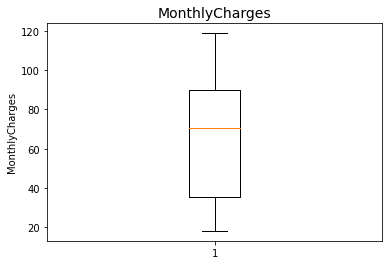

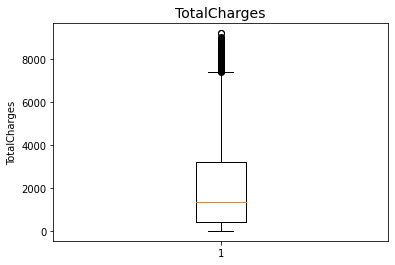

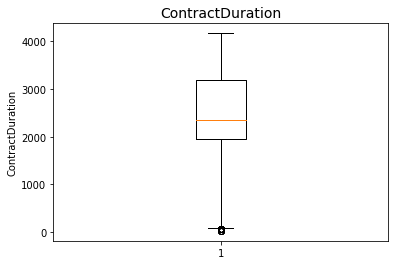

In [ ]:
plot_box(contract_df_replaced)

В столбце MonthlyCharges выбросов нет.
В столбце TotalCharges есть выбросы, но их не такое большое количество. Также мы точно не знаем, почему у клиентов существуют расходы больше

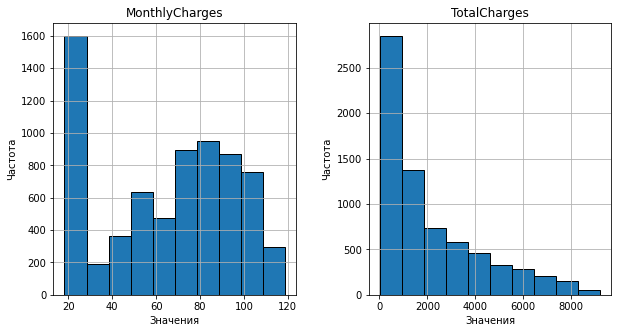

In [ ]:
ax = contract_df_replaced[['MonthlyCharges', 'TotalCharges']].hist(figsize=(10, 5), edgecolor='k')

# Настройка осей для каждого подграфика
for a in ax.flatten():
    a.set_xlabel('Значения')  # Подпись оси X
    a.set_ylabel('Частота')   # Подпись оси Y

# Отображение графика
plt.show()

На первом графике видно, что большинство значений сосредоточены в диапазоне от 20 до 30 (с довольно сильным пиком на значении около 20), а затем наблюдается уменьшение частоты значений с увеличением расходов, хотя есть и несколько пиков на более высоких значениях, близких к 80.

На втором графике видно, что большинство значений сосредоточены в диапазоне от 0 до 1000 (с довольно сильным пиком на значении около 1000), а далее видим достаточно плавное уменьшение частоты значений с последующим увеличением расходов. Это говорит о том, что в основном пользователи имеют небольшие общие расходы, а более высокие встречаются реже.

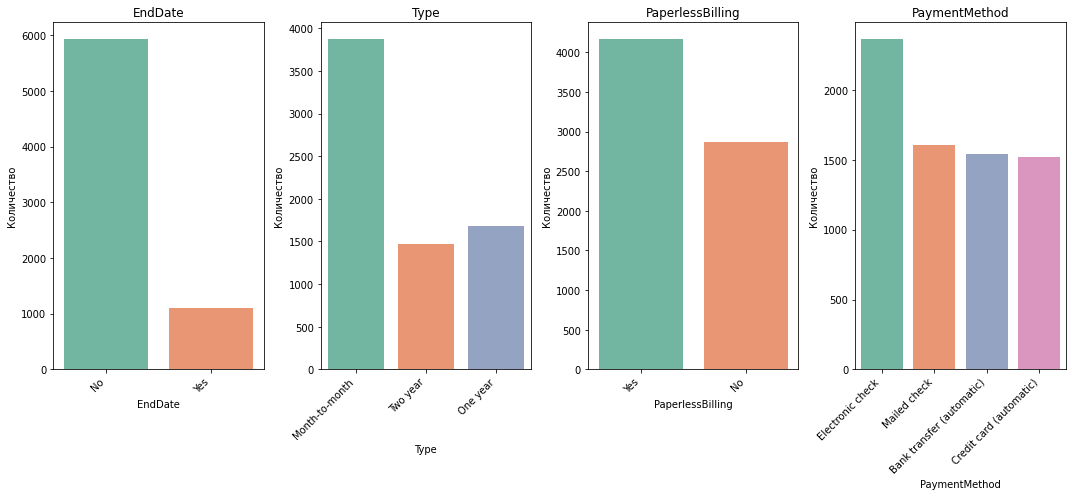

In [ ]:
fig, axes = plt.subplots(1, len(contract_df_replaced.drop(['CustomerID', 'BeginDate'], axis=1).select_dtypes('object').columns),
                         figsize=(15, 7))

for i, name in enumerate(contract_df_replaced.drop(['CustomerID', 'BeginDate'], axis=1).select_dtypes('object').columns):
    ax = axes[i]  # обращаемся к каждой оси
    sns.countplot(x=name, data=contract_df_replaced, palette='Set2', ax=ax)

    # Получаем уникальные значения для текущего столбца
    categories = contract_df_replaced[name].value_counts().index.tolist()

    # Устанавливаем метки на оси X для текущего столбца
    ax.set_xticklabels(categories, rotation=45, ha='right')  # Поворачиваем метки
    ax.set_ylabel('Количество')
    ax.set_title(name)

plt.tight_layout()
plt.show()

В каждом из столбцов наблюдается дисбаланс классов, особенно в нашей целевой переменной (EndDate). Чтобы устранить его будем использовать стратификацию при обучении моделей.  

Построим матрицу корреляции

In [ ]:
def phk_matrix(df):
    # вычисление коэффициентов корреляции phi для датафрейма df
    phik_overview = df.phik_matrix()

    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"correlation $\phi_K$",
        fontsize_factor=1.5,
        figsize=(15, 12)
    )

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractDuration']


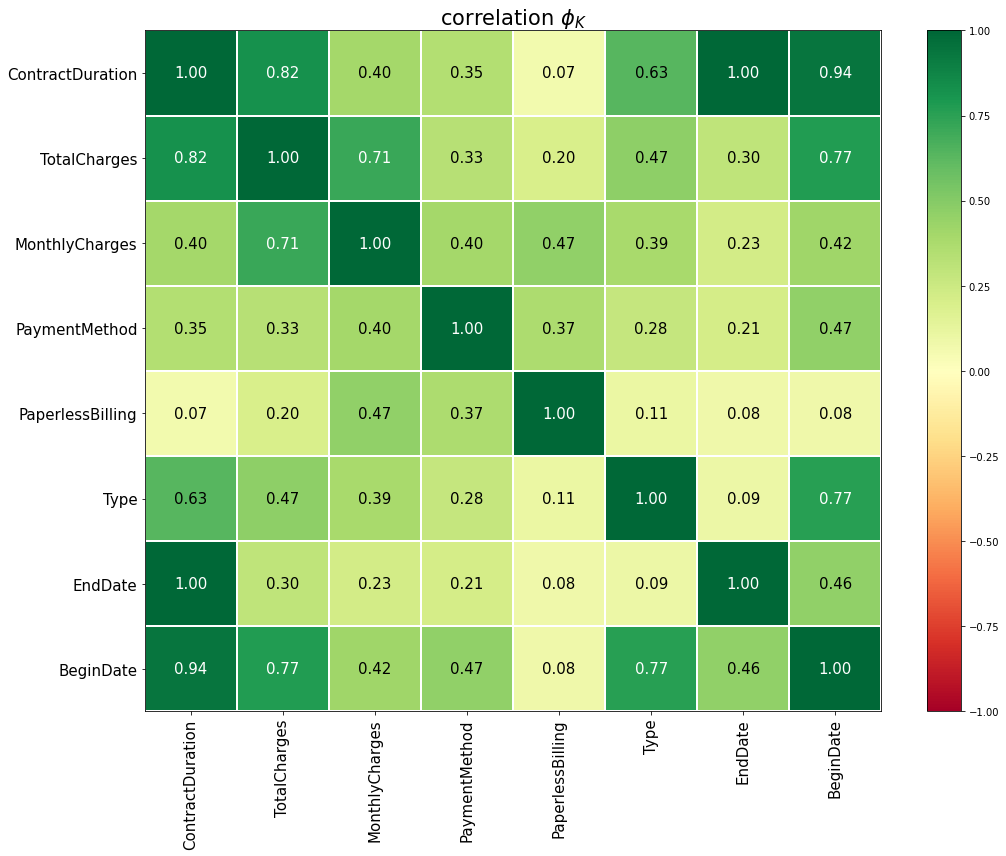

In [ ]:
phk_matrix(contract_df_replaced.drop('CustomerID', axis=1))

Заметим высокую корреляцию между:   
1) BeginDate (дата начала действия договора) и TotalCharges (общие расходы);  
2) BeginDate (дата начала действия договора) и Type (тип оплаты: раз в год-два или ежемесячно): Это может быть связано с тем, что данные типы могут быть распределены в зависимости от времени начала;  
3) TotalCharges(общие расходы) и MonthlyCharges(расходы за месяц): логично, ведь ежемесячные расходы влияют на общие расходы. Чем выше MonthlyCharges, тем выше TotalCharges.  

#### personal_df

In [ ]:
# Проведем статистический анализ признаков
personal_df.describe(include='all')

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,4301-VVZKA,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Видим, что в основном у партенра нет супруги/супруга и нет детей.

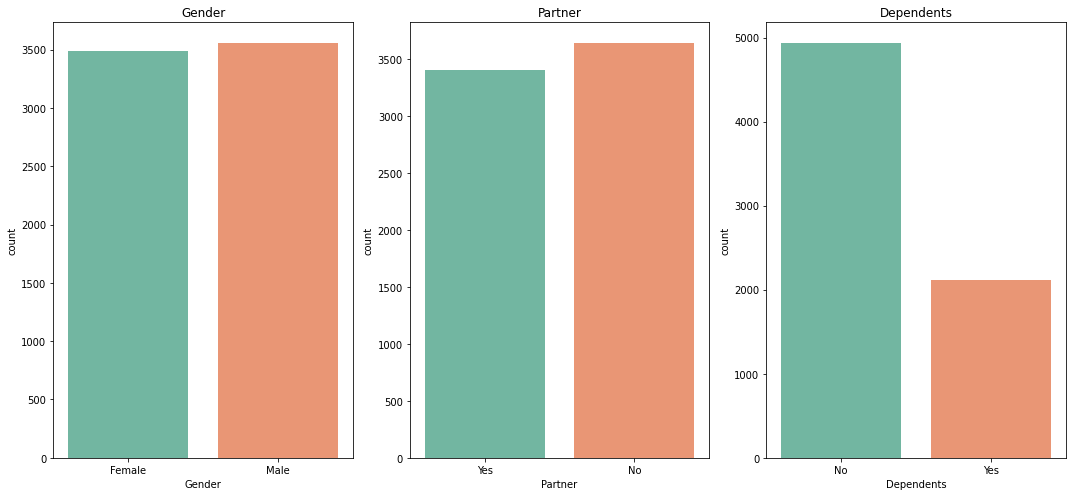

In [ ]:
fig, axes = plt.subplots(1, len(personal_df.drop('CustomerID', axis=1).select_dtypes('object').columns),
                         figsize=(15, 7))

for i, name in enumerate(personal_df.drop('CustomerID',axis=1).select_dtypes('object').columns):
    ax = axes[i]  # обращаемся к каждой оси
    sns.countplot(x=name, data=personal_df, palette='Set2', ax=ax)

    # Получаем уникальные значения для текущего столбца
    categories = personal_df[name].value_counts().index.tolist()

    ax.set_title(name)

plt.tight_layout()
plt.show()

Дисбаланс классов наблюдается на последнем графике (Dependents - ести ли дети у абонента). Это говорит о том, что у большинства абонентов нет детей.

interval columns not set, guessing: ['SeniorCitizen']


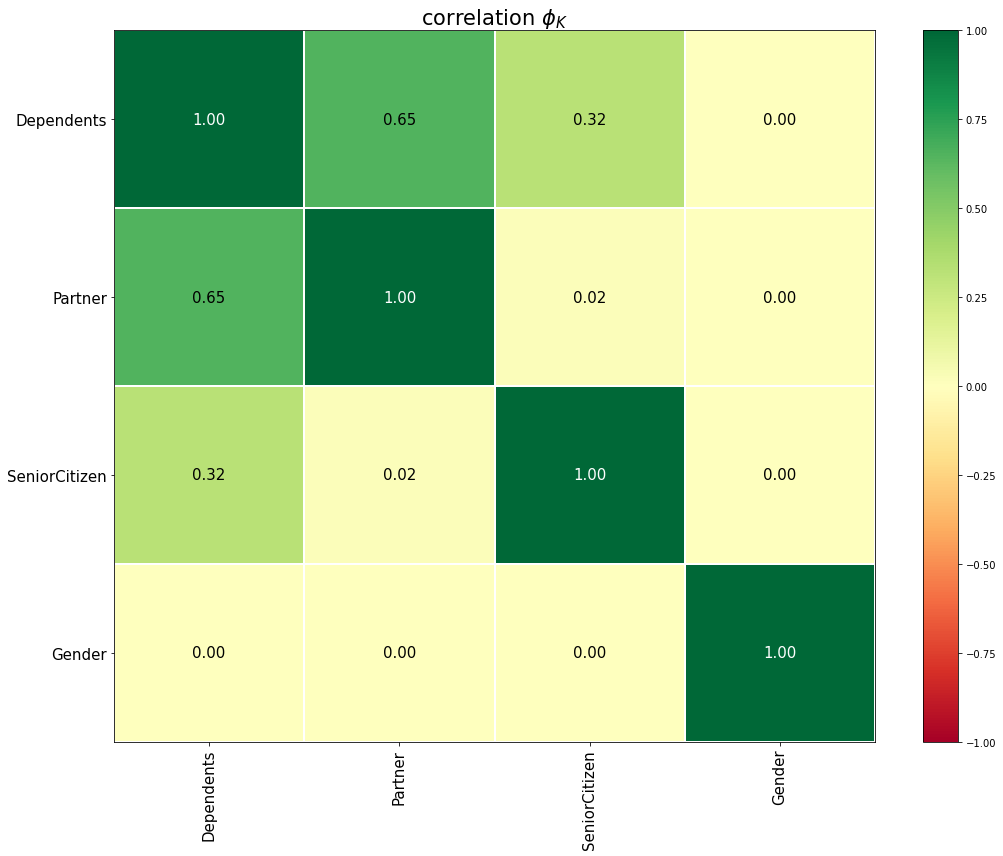

In [ ]:
phk_matrix(personal_df.drop('CustomerID', axis=1))

Заметим высокую корреляцию между Dependents (есть ли у абонента дети) и Partner (есть ли супруг или супруга у абонента):логично, наличие детей, гарантирует наличие партнера.

#### internet_df

In [ ]:
# Проведем статистический анализ признаков
internet_df.describe(include='all')

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3370-HXOPH,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


В основом абоненты подключают интернет через оптоволоконный кабель, потому что данное подключение обеспечивает высокую помехоустойчивость, неограниченный скоростной потенциал и, что самое главное, дешевизну.

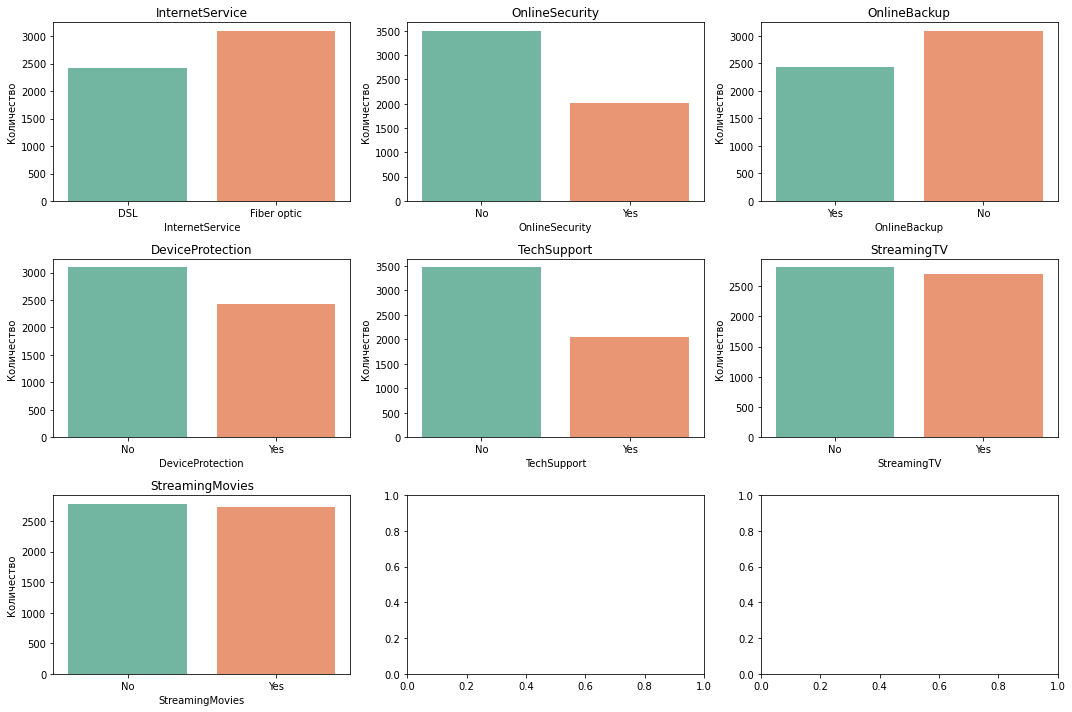

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 3 строки и 3 столбца
axes = axes.flatten()
for i, name in enumerate(internet_df.drop('CustomerID', axis=1).select_dtypes('object').columns):
    ax = axes[i]  # Получаем соответствующую ось для каждого графика
    sns.countplot(x=name, data=internet_df, palette='Set2', ax=ax)

    # Получаем уникальные значения для текущего столбца
    categories = internet_df[name].value_counts().index.tolist()
    ax.set_ylabel('Количество')
    ax.set_title(name)

plt.tight_layout()  # Для корректного отображения
plt.show()


Сильного дисбаланса не наблюдается.

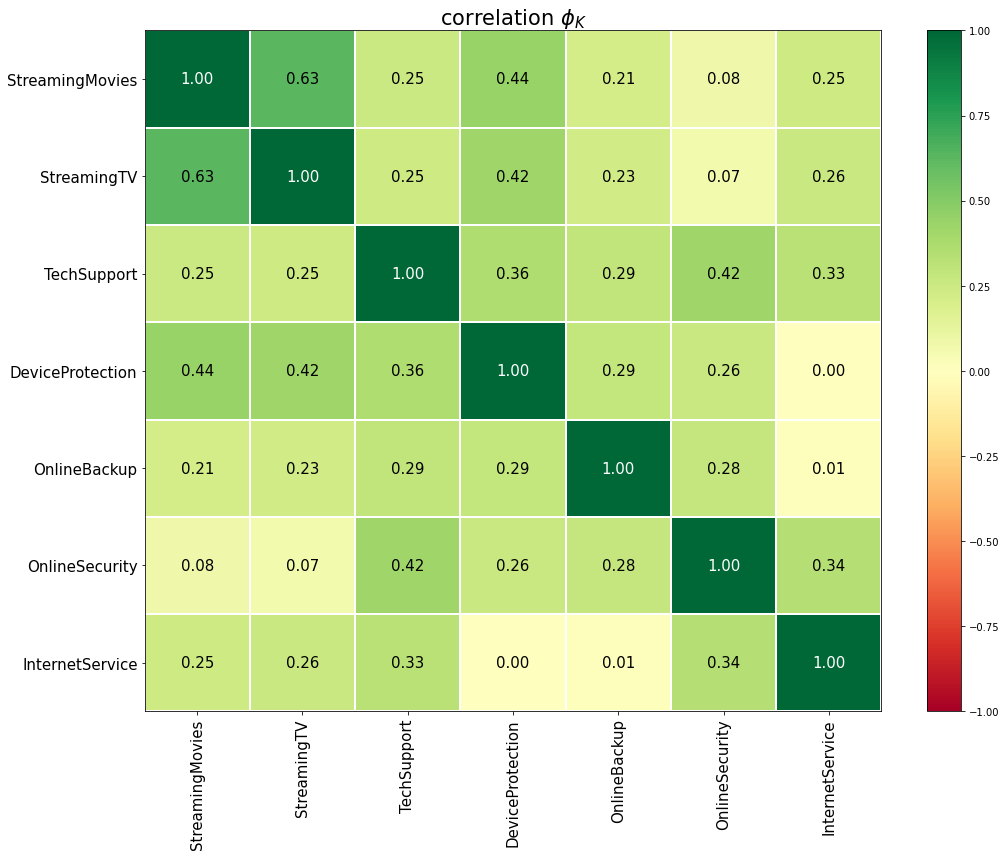

In [ ]:
phk_matrix(internet_df.drop('CustomerID', axis=1))

Высокая корреляция между StreamingTV и StreamingMovies указывает на то, что пользователи, которые пользуются стриминговым телевидением (StreamingTV), с большой вероятностью также используют каталог фильмов (StreamingMovies), и наоборот. Это может быть связано с тем, что оба сервиса предлагают схожий тип контента (видео) и часто предоставляются одной и той же платформой или провайдером.

Средняя корреляция StreamingTV и StreamingMovies с DeviceProtection (0.44 и 0.42 соответственно) говорит о том, что пользователи, активно использующие стриминговые сервисы, также склонны заботиться о защите устройств (DeviceProtection).

Средняя корреляция между TechSupport и OnlineSecurity указывает на то, что пользователи, которые используют антивирус (OnlineSecurity), также склонны обращаться за технической поддержкой (TechSupport).

#### phone_df

In [ ]:
# Проведем статистический анализ признаков
phone_df.describe(include='all')

,CustomerID,MultipleLines
count,6361,6361
unique,6361,2
top,4301-VVZKA,No
freq,1,3390


Видим, что в основном телефон не имеет подлкючения к нескольким линиям одновременно.

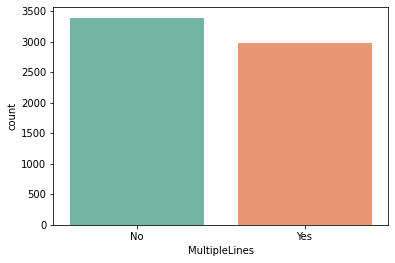

In [ ]:
sns.countplot(x='MultipleLines', data=phone_df, palette='Set2')
plt.show()

Сильного дисбаланса классов не наблюдается

__Вывод по исследовательскому анализу данных:__
1. Провели статистический анализ;
2. Выявили дисбаланс целевой переменной;
3. Провели корреляционный анализ;
4. Выявили выбросы.

## 4. Объединение таблиц

In [ ]:
# Объединим таблицы в одну
final_df = contract_df_replaced.merge(personal_df, on='CustomerID', how='left') \
                 .merge(internet_df, on='CustomerID', how='left') \
                 .merge(phone_df, on='CustomerID', how='left')

Пробоваал соединение типа inner. Объединение получалось без пропусков, но гораздно меньше данных.

In [ ]:
final_df.head() # Первые 5 строк

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01 00:00:00,No,Month-to-month,Yes,Electronic check,29.85,31.04,1882,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01 00:00:00,No,One year,No,Mailed check,56.95,2071.84,2887,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01 00:00:00,No,Month-to-month,Yes,Mailed check,53.85,226.17,1974,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01 00:00:00,No,One year,No,Bank transfer (automatic),42.30,1960.60,3222,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01 00:00:00,No,Month-to-month,Yes,Electronic check,70.70,353.50,2004,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
print(f'Количество строк - {final_df.shape[0]}\nКоличество столбцов - {final_df.shape[1]}')

Количество строк - 7032
Количество столбцов - 21


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   ContractDuration  7032 non-null   int64  
 9   Gender            7032 non-null   object 
 10  SeniorCitizen     7032 non-null   int64  
 11  Partner           7032 non-null   object 
 12  Dependents        7032 non-null   object 
 13  InternetService   5512 non-null   object 
 14  OnlineSecurity    5512 non-null   object 
 15  OnlineBackup      5512 non-null   object 
 16  DeviceProtection  5512 non-null   object 


Создадим новый признак - какую долю от общей суммы составляют ежемесячные платежи.
Высокое значение этого соотношения может указывать на то, что клиент недавно начал пользоваться услугами или имеет высокие ежемесячные расходы относительно общей суммы.

In [ ]:
final_df['ChargesRatio'] = final_df['MonthlyCharges'] / final_df['TotalCharges']

In [ ]:
final_df['ChargesRatio'].head()

0    0.961662
1    0.027488
2    0.238095
3    0.021575
4    0.200000
Name: ChargesRatio, dtype: float64

Еще один новый признак

In [ ]:
# сезон (весна, лето, осень, зима), в который клиент начал пользоваться услугами.
final_df['Season'] = final_df['BeginDate'].apply(lambda x:
    'Winter' if x.month in [12, 1, 2] else
    'Spring' if x.month in [3, 4, 5] else
    'Summer' if x.month in [6, 7, 8] else
    'Autumn'
)

In [ ]:
# Часть датасета с пропусками
final_df[final_df.isnull().any(axis=1)].head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,Gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ChargesRatio,Season
0,7590-VHVEG,2020-01-01 00:00:00,No,Month-to-month,Yes,Electronic check,29.85,31.04,1882,Female,...,DSL,No,Yes,No,No,No,No,NaN,0.961662,Winter
3,7795-CFOCW,2016-05-01 00:00:00,No,One year,No,Bank transfer (automatic),42.30,1960.60,3222,Male,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0.021575,Spring
7,6713-OKOMC,2019-04-01 00:00:00,No,Month-to-month,No,Mailed check,29.75,300.48,2157,Female,...,DSL,Yes,No,No,No,No,No,NaN,0.099008,Spring
11,7469-LKBCI,2018-10-01 00:00:00,No,Two year,No,Credit card (automatic),18.95,312.30,2339,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0.060679,Autumn
16,8191-XWSZG,2015-10-01 00:00:00,No,One year,No,Mailed check,20.65,1106.01,3435,Female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0.018671,Autumn


Почему образовались пропуски:
Так как клиенты выбирают из всего списка то, что надо им (чем они будут пользоваться), соответственно, можно предположить, что пропуски как то, что клиенты не выбрали для личного пользования (как вариант - это клиенты с низкими общими тратами)

Да, действительно, заполнить наиболее частым значением будет неверно, но и удалить мы не можем, так как потеряем много данных. Тогда заменим NaN на 0 (как строка)

In [ ]:
final_df.fillna('0', inplace=True)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   ContractDuration  7032 non-null   int64         
 9   Gender            7032 non-null   object        
 10  SeniorCitizen     7032 non-null   int64         
 11  Partner           7032 non-null   object        
 12  Dependents        7032 non-null   object        
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

Пропуски устранены

In [ ]:
# Посмотрим на уникальные значения
check_unique_val(final_df)

2014-02-01    366
2019-09-01    237
2019-11-01    237
2019-10-01    237
2020-01-01    233
             ... 
2016-11-01     50
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 76, dtype: int64 

No     5931
Yes    1101
Name: EndDate, dtype: int64 

Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64 

Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64 

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64 

20.05    61
19.90    44
19.95    44
19.85    44
19.65    43
         ..
39.95     1
18.55     1
39.55     1
18.75     1
97.25     1
Name: MonthlyCharges, Length: 1584, dtype: int64 

20.45      6
101.00     5
1007.50    4
21.53      4
732.60     4
          ..
188.10     1
1213.10    1
2035.20    1
480.41     1
96.94      1
Name: TotalCharges, Length: 6657, dtype: int64 

Пустых строк, неянвых дубликатов не обнаружено

In [ ]:
print(f'Количество дубликатов = {final_df.duplicated().sum()}')

Количество дубликатов = 0


In [ ]:
# Проведем статистический анализ признаков
final_df.describe(include='all')

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,Gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ChargesRatio,Season
count,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032.000000,7032,...,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032
unique,7032,76,2,3,2,4,NaN,NaN,NaN,2,...,3,3,3,3,3,3,3,3,NaN,4
top,4301-VVZKA,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,Male,...,Fiber optic,No,No,No,No,No,No,No,NaN,Winter
freq,1,366,5931,3875,4168,2365,NaN,NaN,NaN,3549,...,3096,3497,3087,3094,3472,2809,2781,3385,NaN,2020
first,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2118.621822,2461.150313,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113554,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2112.736199,950.899725,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192706,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,19.050000,28.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012626,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,439.745000,1943.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020421,NaN


Посмотрев на стандартное отклонение (std), видим, что в данных нет большого разброса относительно их среднего значения

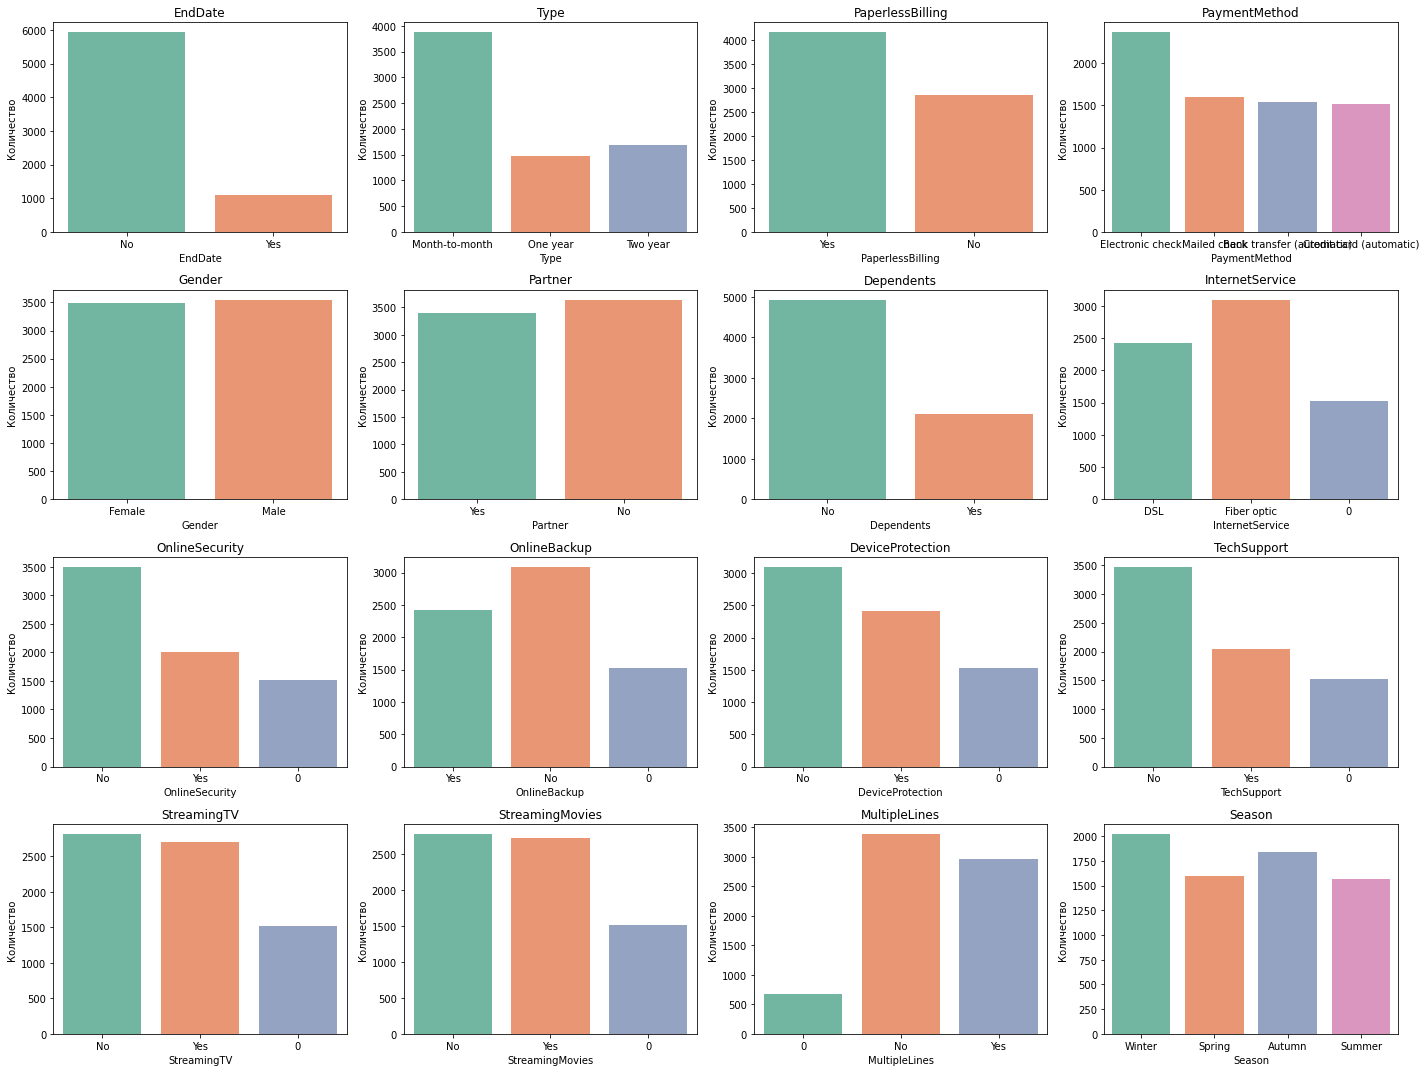

In [ ]:
# Количество категориальных признаков
num_plots = len(final_df.drop(['CustomerID', 'BeginDate'], axis=1).select_dtypes('object').columns)

fig, axes = plt.subplots(4, 4, figsize=(20, 15))

# Преобразуем оси в одномерный массив
axes = axes.flatten()

for i, name in enumerate(final_df.drop(['CustomerID', 'BeginDate'], axis=1).select_dtypes('object').columns):
    ax = axes[i]  # Получаем соответствующую ось для каждого графика
    sns.countplot(x=name, data=final_df, palette='Set2', ax=ax)

    # Получаем уникальные значения для текущего столбца
    categories = final_df[name].value_counts().index.tolist()

    # Устанавливаем метки на оси X для текущего столбца
    #ax.set_xticklabels(categories, rotation=45)  # Поворачиваем метки
    ax.set_ylabel('Количество')
    ax.set_title(name)

plt.tight_layout()  # Для корректного отображения
plt.show()


В целевой переменной EndDate дисбаланс классов сохранился. По новому признаку Season видим, что большая часть клиентов начал обслуживаться зимой.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'SeniorCitizen', 'ChargesRatio']


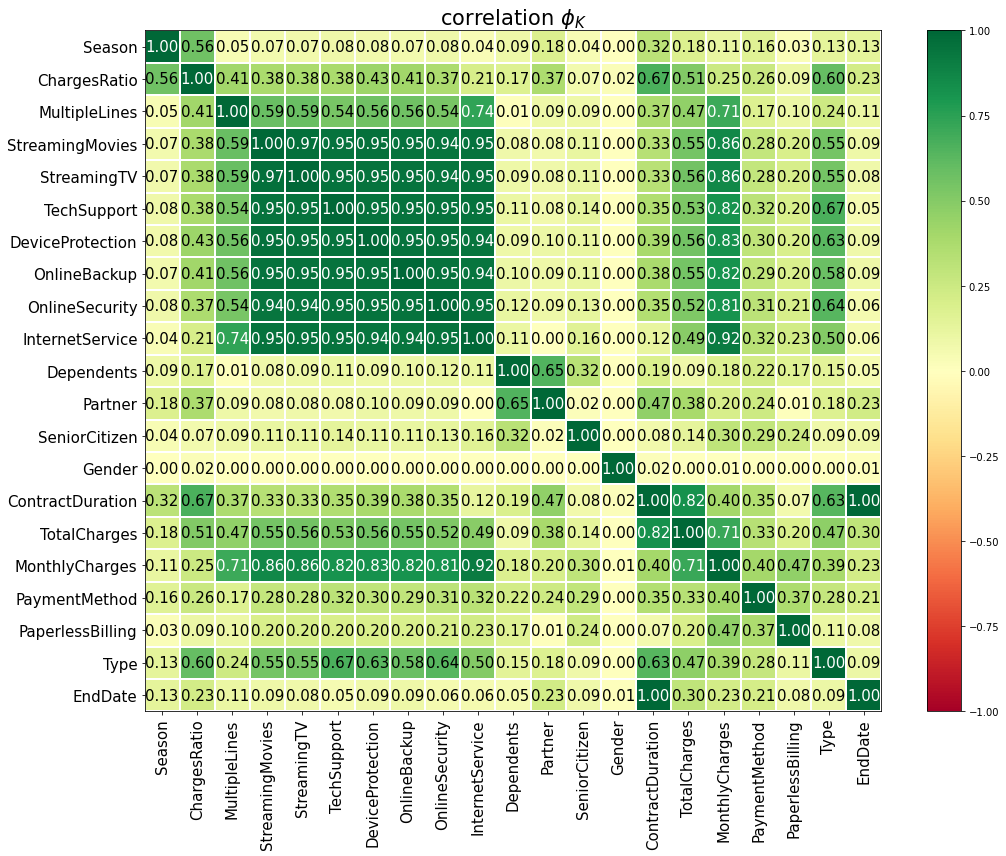

In [ ]:
phk_matrix(final_df.drop(['CustomerID', 'BeginDate'], axis=1))

Признак Gender практически ни с чем не коррелирует, поэтому его мы не используем для обучения.  
Так как перед нами задача классификации, то признаки с датами в обучение не берем.

__Вывод по объединению таблиц:__
1. Объединили 4 датасета в 1;
2. Просмотрели корреляцию с целевой переменной;
3. Добавили новые признаки.

## 5. Обучение и тестирование модели

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# Целевой признак и данные
X = final_df.drop(['CustomerID', 'BeginDate', 'EndDate', 'Gender', 'TotalCharges',
                   'ContractDuration'], axis=1)
y = final_df['EndDate']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

print(X_train.shape, X_test.shape)

(1758, 17) (5274, 17)


In [ ]:
# Пайплайн для OHE-кодирования и заполнения пропусков
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))]
)

# # Пайплайн для OrdinalEncoder для признака 'cellphone_in_use'
# ord_pipe = Pipeline(
#     [('simpleImputer_ordinal', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#      ('ordinal', OrdinalEncoder())]
# )

# Общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, [
                        'Partner',
                        'Dependents',
                        'InternetService',
                        'OnlineSecurity',
                        'OnlineBackup',
                        'DeviceProtection',
                        'TechSupport',
                        'StreamingTV',
                        'StreamingMovies',
                        'MultipleLines',
                        'Type',
                        'PaymentMethod',
                        'PaperlessBilling',
                        'Season']),

     ('num', StandardScaler(), ['MonthlyCharges', 'ChargesRatio'])
    ],
    remainder='passthrough'
)

# Итоговый пайплайн: подготовка данных, SMOTE и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),  # Предобработка данных
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))  # Модель
])

# Параметры для поиска
param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [10, 50, 100, 500],
        'models__max_depth': [5, 10, 50, 100],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

        # Словарь для модели MLPClassifier (нейронная сеть)
    {
        'models': [MLPClassifier(random_state=RANDOM_STATE)],
        'models__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'models__activation': ['relu', 'tanh', 'sigmoid'],
        'models__solver': ['adam', 'sgd'],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели GradientBoostingClassifier (бустинг)
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 500],
        'models__learning_rate': [0.00001, 0.001, 0.02, 0.1],
        'models__max_depth': [3, 5, 20, 50],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__penalty': ['l2', 'l1'],  # регуляризация L2 или без регуляризации
        'models__C': [0.1, 1, 10, 50, 100],  # параметр регуляризации
        'models__solver': ['lbfgs', 'liblinear'],  # алгоритм оптимизации
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели XGBoost
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 500],
        'models__learning_rate': [0.0000001, 0.0001, 0.001, 0.1],
        'models__max_depth': [3, 5, 10, 50, 100],
        'models__subsample': [0.8, 1.0],  # доля выборки для обучения
        'models__colsample_bytree': [0.8, 1.0],  # доля признаков для дерева
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

        # Словарь для модели CatBoost
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, silent=True)],
        'models__iterations': [100, 200, 500],  # количество итераций
        'models__learning_rate': [0.00001, 0.001, 0.01],  # скорость обучения
        'models__depth': [3, 5, 10, 50, 100],  # глубина деревьев
        'models__l2_leaf_reg': [1, 3, 5, 50],  # регуляризация
        'models__border_count': [32, 64, 128],  # количество разбиений для признаков
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 500],
        'models__learning_rate': [0.0001, 0.01, 0.3],
        'models__max_depth': [3, 5, 10, 50, 100],
        'models__num_leaves': [31, 50, 100, 200],  # количество листьев
        'models__min_child_samples': [20, 30, 50, 100],  # минимальное количество образцов в листе
        'models__subsample': [0.8, 1.0],  # доля выборки для обучения
        'models__colsample_bytree': [0.8, 1.0],  # доля признаков для дерева
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

# Поиск лучшей модели
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=stratified_kfold,
    scoring='roc_auc',
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

[23:30:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Преобразуем целевую переменную 'EndDate' в числовые значения
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
y_pred = random_search.best_estimator_.predict(X_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Получаем вероятности классов для положительного класса (1)
y_test_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]
# ROC-AUC на тестовой выборке

roc_auc = roc_auc_score(y_test_encoded, y_test_pred_proba)
print(f"Метрика ROC-AUC на тестовой выборке: {roc_auc}")

Метрика ROC-AUC на тестовой выборке: 0.8508276157524344


По построенной выше матрице корреляции, мы видим, что у целевого признака EndDate и нового признака ContractDuration корреляция равна 1.00. Данный признак был создан на разнице целевого признака EndDate и признака BeginDate. Поэтому и произошла та самая утечка данных. Не будем использовать созданный признак.

In [ ]:
def plot_learning_curve(estimator, X, y, cv, scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Построение кривой обучения.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    # Средние значения и стандартные отклонения
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Построение графика
    plt.figure(figsize=(10, 6))
    # dotted blue line is for training scores and green line is for cross-validation score
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",  label="Training score")
    plt.plot(train_sizes, val_scores_mean, color="g", label="Cross-validation score")

    plt.title("Кривая обучения")
    plt.xlabel("Размер обучающей выборки")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

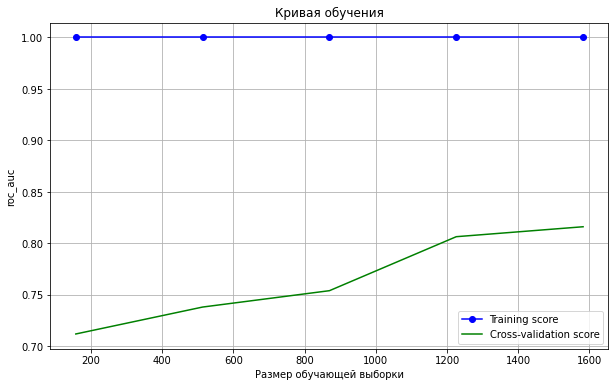

In [ ]:
best_model = random_search.best_estimator_
# Построение кривой обучения
plot_learning_curve(best_model, X_train, y_train, cv=stratified_kfold, scoring="roc_auc")

Модель на обучении:
Линия находится постоянно на уровне 1 Это означает, что модель очень хорошо обучается на данных и показывает идеальный результат на обучающем наборе.

Модель на валидации:
Чем больше данных, тем выше становится метрика. Это говорит о том, что модель не страдает от переобучения, и с увеличением данных она продолжает улучшать свою способность обобщать на новые данные.

In [ ]:
print(classification_report(y_test_encoded, y_pred_encoded))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4448
           1       0.68      0.42      0.52       826

    accuracy                           0.88      5274
   macro avg       0.79      0.69      0.72      5274
weighted avg       0.86      0.88      0.87      5274



**Precision** можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными: для класса 1 точность 0.68 означает, что из всех предсказаний, что клиент ушел, 68% были правильными.   
**recall** показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм: для класса 1 полнота 0.42 означает, что модель обнаружила только 42% случаев, когда клиент действительно ушел.


In [ ]:
precision, recall, _ = precision_recall_curve(y_test_encoded, y_test_pred_proba)

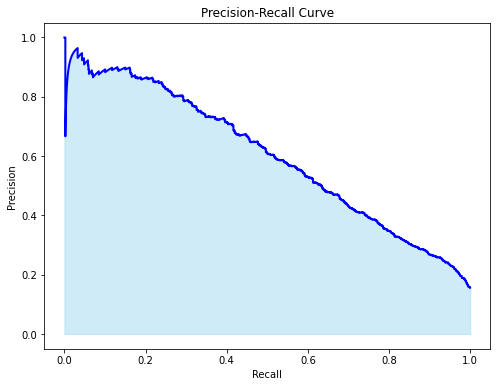

In [ ]:
# Построение графика Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.fill_between(recall, precision, color='skyblue', alpha=0.4)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Закрашенная область (AUC-PR): Площадь под кривой Precision-Recall (AUC-PR). Чем больше эта площадь, тем лучше модель справляется с задачей классификации, особенно в условиях несбалансированных классов.

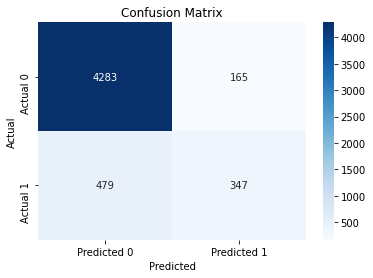

In [ ]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)

# Визуализация матрицы ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Actual 0 (реальные 0):

True Negatives (TN): 4283 — модель правильно классифицировала 4283 примера как "не ушедшие клиенты".   
False Positives (FP): 165 — модель ошибочно предсказала 165 примеров, что клиент ушел (класс 1), хотя на самом деле клиент остался.  

Actual 1 (реальные 1):

False Negatives (FN): 479 — модель ошибочно предсказала 479 примеров из класса "1" (ушедшие клиенты) как класс "0" (не ушедшие клиенты).  
True Positives (TP): 347 — модель правильно классифицировала 347 примеров как "ушедшие клиенты".

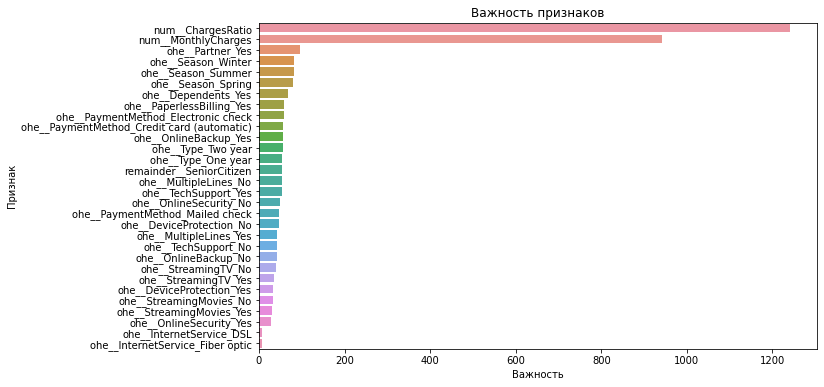

In [ ]:
# Извлечение важности признаков
feature_importances = random_search.best_estimator_.named_steps['models'].feature_importances_

# Получение имен признаков
feature_names = random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Создание DataFrame для удобства анализа
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка признаков по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

Наиболее важные признаки для модели:    
1) Доля от общей суммы, которую составляют ежемесячные платежи;   
2) Ежемесячные платежи;  
3) Наличие партнера;  
4) Месяц - зима;  
5) Месяц - лето;  
6) месяц - весна;  
7) Наличие детей;   

In [ ]:
important_feature = importance_df.iloc[1]['Feature'].split('num__')[1]
important_feature

'MonthlyCharges'

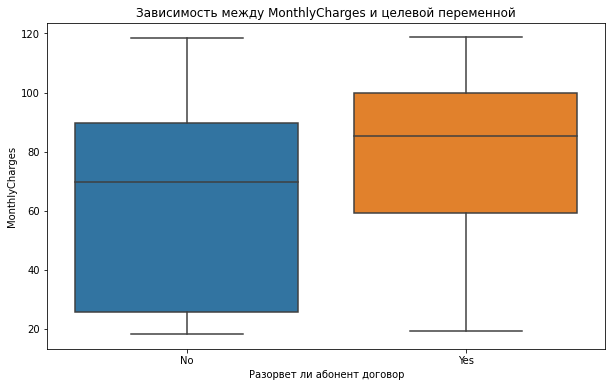

In [ ]:
# Построение графика зависимости между важным признаком и целевой переменной
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_train, y=X_train[important_feature])
plt.title(f'Зависимость между {important_feature} и целевой переменной')
plt.xlabel('Разорвет ли абонент договор')
plt.ylabel(important_feature)
plt.show()

Для клиентов, которые не ушли ("No"), медианное значение MonthlyCharges значительно ниже, чем для тех, кто покинул компанию ("Yes").
Это может указывать на то, что клиенты с высокими расходами чаще уходят, а клиенты с меньшими расходами остаются.

__Вывод по обучению и тестированию модели:__  
1. Разбили датасет на обучающую и тестовую выборки;
2. Обучили модель: лучшая модель - CatBoostClassifier.   
Метрика на обучении - 1; Метрика на тесте - 1;
3. Выявили наиболее важные признаки для модели;
4. Сравнили один из важных признаков с целевой переменной.

## 6. Вывод по проекту

__Вывод по загрузке данных__:

1. Загрузили данные;  
2. Проанализировали датасеты - заметили общий столбец customerID.  

__Вывод по преобработке данных:__
1. Изучили общую информацию по каждому датасету;
2. Подготовили целевую переменную EndDate;
3. Поменяли типы данных там, где это потребовалось;
4. Удалили пустые строки в датасете contract_df, так как их количество очень маленькое.
  
__Вывод по исследовательскому анализу данных:__  
1. Провели статистический анализ;  
2. Выявили дисбаланс целевой переменной;  
3. Провели корреляционный анализ;  
4. Выявили выбросы.  


__Вывод по объединению таблиц:__
1. Объединили 4 датасета в 1;  
2. Просмотрели корреляцию с целевой переменной;  

__Вывод по обучению и тестированию модели:__  
1. Разбили датасет на обучающую и тестовую выборки;
2. Обучили модель: LGBMClassifier;  
* Метрика на тренировочной выборке: 0.8167950188923344  
* Метрика на тесте - 0.8508276157524344;
3. Выявили наиболее важные признаки для модели;
4. Сравнили один из важных признаков с целевой переменной.


__Бизнес-рекомендации заказчику:__  
Если уходят клиенты, у которых высокие общие затраты, значит они в поисках услуг по соотношению цены и качества. Может, в другой компании за эту сумму они получают больше услуг или, наоборот, им предлагают акции, бонусы или делают скидки.
Поэтому стоит рассмотреть внедрение промокодов, акций, накопительные карты клиента на услуги с высокой стоимостью.